### This code uses random forest to analyze the impact of each feature on SalePrice. The code initially groups data by street and examines the impact of each feature on SalePrice for each of the ten street groups. However, the code can be modified to analyze the entire dataset or to group the data by other factors, such as neighborhoods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

<IPython.core.display.Javascript object>

In [2]:
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [3]:
# Dropping PID and correlated features

housing.drop(
    ["PID", "Neighborhood", "2ndFlrSF"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

In [4]:
# function to create categorical quantiles for street groupings
def group_neighbor_streets_by_saleprice(
    housing,
    num_quantiles=10,
):
    # Calculate the mean sale price for each street in the housing df
    street_prices = housing.groupby("Neighborhood_st")["SalePrice"].mean()
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f"group_{i+1}" for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=labels)  # Use 'labels' variable here
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    # Add a new column to the housing dataframe with the street price groups
    housing["StreetPriceGroup"] = housing["Neighborhood_st"].map(street_group_dict)
    return street_group_dict


<IPython.core.display.Javascript object>

In [5]:
# Running the function
street_group_dict = group_neighbor_streets_by_saleprice(housing=housing, num_quantiles=10)


<IPython.core.display.Javascript object>

In [6]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)
# keeping StreetPriceGroup​ since it will be used later
cat_features.remove("StreetPriceGroup")

<IPython.core.display.Javascript object>

In [7]:
from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Using Random Forest to select the top 6 features in each of the groupings 

In [13]:
"""
This script performs the following tasks:

1. Encodes the 'StreetPriceGroup' column using label encoding.
2. Trains a Random Forest Regressor for each 'StreetPriceGroup' to predict 'SalePrice'.
3. Extracts and prints the top 6 important features for each 'StreetPriceGroup'.
4. Calculates and prints the mean absolute SHAP values for the top 6 important features in each 'StreetPriceGroup'.
"""


# Create a label encoder instance
label_encoder = LabelEncoder()

# Encode the neighborhood column and store the mapping
housing['StreetPriceGroupEncoded'] = label_encoder.fit_transform(housing['StreetPriceGroup'])
StreetPriceGroup_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Get unique neighborhoods
unique_StreetPriceGroup = housing['StreetPriceGroup'].unique()

shap_values_dict = {}

# Loop through each neighborhood
for StreetPriceGroup in unique_StreetPriceGroup:
    print(f"Analyzing StreetPriceGroup: {StreetPriceGroup}")

    # Filter data based on the neighborhood
    StreetPriceGroup_data = housing[housing['StreetPriceGroup'] == StreetPriceGroup]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(StreetPriceGroup_data.drop(["SalePrice", "StreetPriceGroup", "StreetPriceGroupEncoded"], axis=1),
                                                        StreetPriceGroup_data["SalePrice"], test_size=0.2, random_state=42)

    # Train the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Calculate feature importances
    feature_importances = rf.feature_importances_

    # Analyze the feature importances
    important_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances}).sort_values('Importance', ascending=False).head(6)

    print(important_features)

    # Calculate SHAP values for the top 6 features
    explainer = shap.Explainer(rf, X_train)
    shap_values = explainer(X_test)

    # Get the SHAP values for the top 6 features
    top_feature_indices = [X_train.columns.get_loc(col) for col in important_features["Feature"].tolist()]  # Get column indices
    top_feature_shap_values = shap_values[:, top_feature_indices]

    # Calculate the mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(top_feature_shap_values.values).mean(axis=0)  # Extract the values from the Explanation object

    # Print the SHAP values
    print("Mean absolute SHAP values:")
    for feature, value in zip(important_features["Feature"], mean_abs_shap_values):
        print(f"{feature}: {value}")

    print("\n")

    # Store the SHAP values in the dictionary for later use
    shap_values_dict[StreetPriceGroup] = shap_values

# Print the mapping between neighborhood names and encoded values
print("StreetPriceGroup mapping:")
print(StreetPriceGroup_mapping)



Analyzing StreetPriceGroup: group_4
        Feature  Importance
60      TotalSF    0.362361
58          Age    0.053340
15  OverallQual    0.046362
3       LotArea    0.044311
59     RemodAge    0.039928
28   BsmtFinSF1    0.038662
Mean absolute SHAP values:
TotalSF: 7811.376721972139
Age: 815.6660285153373
OverallQual: 1182.1049937407497
LotArea: 1245.3486279325825
RemodAge: 1808.4424575276516
BsmtFinSF1: 1173.7393196453768


Analyzing StreetPriceGroup: group_2
        Feature  Importance
60      TotalSF    0.404056
16  OverallCond    0.123360
33   CentralAir    0.050648
3       LotArea    0.037636
59     RemodAge    0.031980
46   GarageArea    0.028399
Mean absolute SHAP values:
TotalSF: 10994.116228918412
OverallCond: 3260.0095275701765
CentralAir: 1288.2249398832744
LotArea: 270.0677640540082
RemodAge: 1142.1629932800993
GarageArea: 787.5327060144072


Analyzing StreetPriceGroup: group_8
        Feature  Importance
60      TotalSF    0.431025
59     RemodAge    0.057088
15  Overall

<IPython.core.display.Javascript object>

In [14]:
# Looking at the mean for all categories that have a group_9 grouping
housing[housing["StreetPriceGroup"] == "group_9"].mean()


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


SalePrice                  257820.542222
MSSubClass                     54.600000
MSZoning                        3.657778
LotFrontage                    58.888889
LotArea                     14170.351111
Street                          1.000000
Alley                           1.017778
LotShape                        1.417778
LandContour                     2.764444
Utilities                       0.000000
LotConfig                       3.075556
LandSlope                       0.120000
Condition1                      2.004444
Condition2                      2.008889
BldgType                        0.675556
HouseStyle                      3.142222
OverallQual                     7.480000
OverallCond                     5.360000
RoofStyle                       1.577778
RoofMatl                        0.155556
Exterior1st                    10.137778
Exterior2nd                    10.862222
MasVnrType                      1.751111
MasVnrArea                    206.653333
ExterCond       

<IPython.core.display.Javascript object>

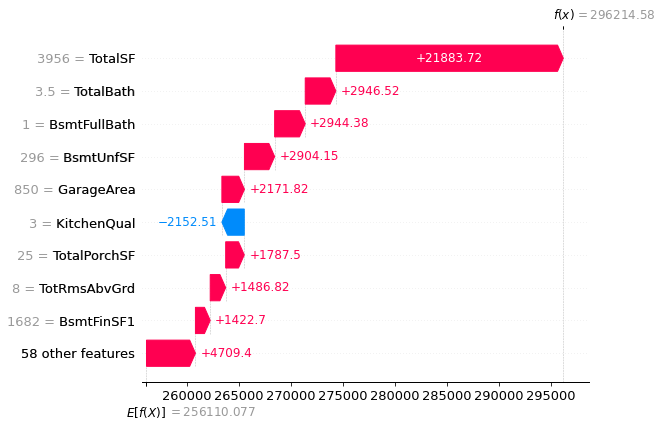

<IPython.core.display.Javascript object>

In [16]:
# Waterfall Plot: Visualizes the SHAP values for a SINGLE instance in a waterfall manner,
# showing the cumulative effect of each feature on the prediction.
StreetPriceGroup_to_plot = 'group_9'   # looking at just this group
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
instance_index = 0  # and the first observation in this group
instance_shap_values = shap_values_to_plot[instance_index]
shap.plots.waterfall(instance_shap_values)


In [17]:
# Force Plot (SINGLE instance): Visualizes the SHAP values for a single instance, 
# showing the contribution of each feature to the model's prediction and is just a condensed waterfall
StreetPriceGroup_to_plot = 'group_9'
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
instance_index = 0
shap.plots.force(shap_values_to_plot[instance_index])


<IPython.core.display.Javascript object>

In [18]:
# Force Plot (all instancesin group 9): Visualizes the SHAP values for multiple instances, 
# showing the contributions of each feature to the model's prediction.
StreetPriceGroup_to_plot = 'group_9'
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
shap.plots.force(shap_values_to_plot)



<IPython.core.display.Javascript object>

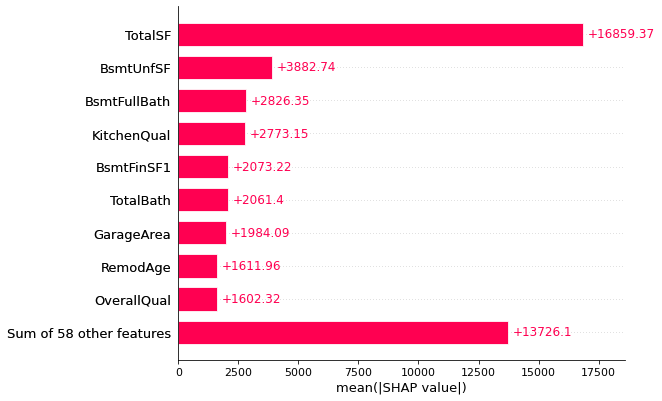

<IPython.core.display.Javascript object>

In [19]:
# Summary Plot: Shows the average impact of each feature on the model's output, ranking them by importance.
StreetPriceGroup_to_plot = 'group_9'
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
shap.plots.bar(shap_values_to_plot)


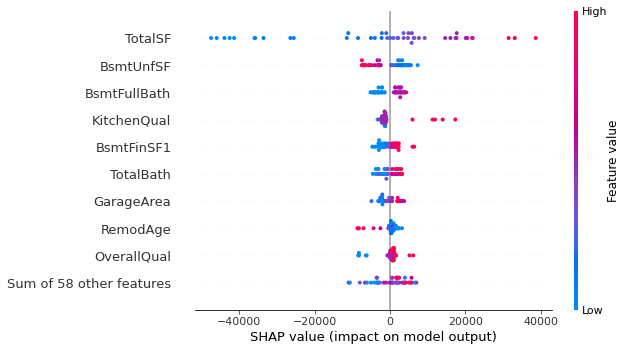

<IPython.core.display.Javascript object>

In [20]:
# Beeswarm Plot: Displays all the SHAP values for each feature, sorted by their magnitude.
StreetPriceGroup_to_plot = 'group_9'
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
shap.plots.beeswarm(shap_values_to_plot)


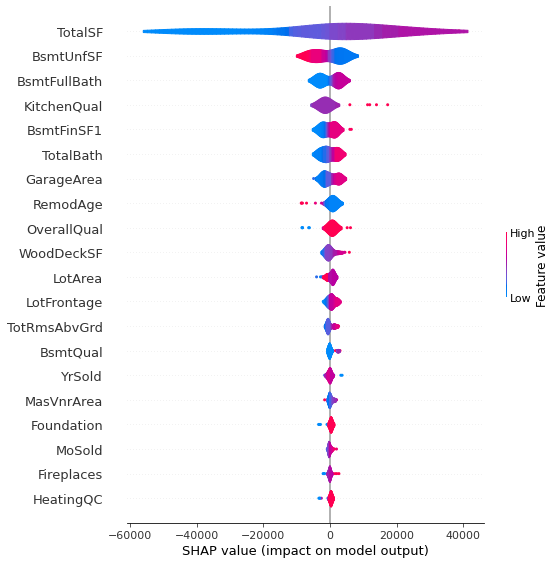

<IPython.core.display.Javascript object>

In [21]:
# Violin Plot: Displays the distribution of SHAP values for each feature.
StreetPriceGroup_to_plot = 'group_9'
shap_values_to_plot = shap_values_dict[StreetPriceGroup_to_plot]
shap_values_to_plot.expected_value = shap_values_to_plot.base_values
shap.plots.violin(shap_values_to_plot)



### Looking at the average dollar increase per one square foot increase although it might be wrong?

In [22]:
"""
This script performs the following tasks:

1. Retrieves the SHAP values for the 'TotalSF' feature.
2. Calculates the ratio between SHAP values and the 'TotalSF' values for instances where 'TotalSF' is not 0.
3. Calculates and prints the average dollar increase per square foot based on the calculated ratios.
"""

# Get SHAP values for the "TotalSF" feature and the corresponding feature values
total_sf_shap_values = shap_values[:, X_test.columns.get_loc("TotalSF")].values
total_sf_values = X_test["TotalSF"].values

# Calculate the ratio between SHAP values and feature values for instances where TotalSF is not 0
non_zero_indices = np.where(total_sf_values != 0)
ratios = np.divide(
    total_sf_shap_values[non_zero_indices], total_sf_values[non_zero_indices]
)

# Calculate the average dollar increase per square foot
average_increase_per_sf = np.mean(ratios)

# Print the average dollar increase per square foot
print(f"Average dollar increase per square foot: {average_increase_per_sf}")


Average dollar increase per square foot: -6.221204764818537


<IPython.core.display.Javascript object>